# Bike sharing case study

## Objective

Identify the significance & extent of variables behind the demand for shared bikes in the American market

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
#load the dataset
inp0 = pd.read_csv('day.csv',header=0)
inp0.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## I - Data understanding

**1. Number of rows & columns**

In [3]:
# number of rows & columns
inp0.shape

(730, 16)

In [4]:
#list all the columns
print(list(inp0.columns))

['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']


**2. Presence of Null or NaN values**

In [5]:
#null values in each colummn
print('Null values : ', [inp0[i].isnull().sum() for i in inp0.columns])

Null values :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [6]:
print('NaN values : ', [inp0[i].isna().sum() for i in inp0.columns])

NaN values :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


**Observation** : No NULL nor NaN values present in dataset.

**3. Identification of data quality issues within the dataset**

In [7]:
inp0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


**Observations**<br>
1. instant : drop column because it contains index numbers which is not relevant for prediction.<br>
2. dteday  : subtract from 01.01.2018(assuming company inception) into a derived variable; drop column since already broken into
columns yr, mnth, weekday.<br>
3. season,weathersit,month,weekday  : categorical value so convert it into string values followed by encoding under data preparation.<br>
4. yr,mnth,cnt : rename column name.<br>
5. temp, atemp, hum, windspeed : round to 2 decimal spaces; standardize under data preparation.<br>
6. casual, registered : unknown during prediction as it requires more information;summation contained in column cnt so all 3 acting as target variable therefore drop these columns.<br>

## II - Data Manipulation

**1. yr,mnth,cnt : rename column name**

In [8]:
#inp0 - initial dataframe read from file
#inp1 - copy of inp0; data manipulation

inp1 = inp0.copy()
inp1.rename(columns={'yr':'year','mnth':'month','cnt':'count'},inplace=True)

**2. Derived metric : subtract dteday from 01.01.2018 assuming this was when the company started operations**

In [9]:
inp1['days_old']=(pd.to_datetime(inp1['dteday'],format= '%d-%m-%Y')-pd.to_datetime('01-01-2018',format= '%d-%m-%Y')).dt.days
inp1.head()

,instant,dteday,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,count,days_old
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,0
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,1
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,2
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,3
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,4


**3. season,weathersit,month,weekday : categorical value so convert it into string values**

Season's numerical values & its corresponding categorical values:<br>
**1:spring<br>
2:summer<br>
3:fall<br>
4:winter**

In [10]:
inp1.season.value_counts()

3    188
2    184
1    180
4    178
Name: season, dtype: int64

In [11]:
inp1.season = inp1.season.map({1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'})

Description of the weather's numerical data & its corresponding categorical values:<br>
**1: Good**     - Clear, Few clouds, Partly cloudy, Partly cloudy<br>
**2: Moderate** - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist<br>
**3: Bad**      - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>
**4: Severe**   - Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog<br>

In [12]:
inp1.weathersit.value_counts()

1    463
2    246
3     21
Name: weathersit, dtype: int64

In [13]:
inp1.weathersit = inp1.weathersit.map({1:'Clear',2:'Misty',3:'Light_snrn',4:'Heavy_snrn'})

In [14]:
inp1.month = inp1.month.apply(lambda x : calendar.month_abbr[x])

In [15]:
inp1.weekday = inp1.weekday.map({0:'Sun',1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'})

In [16]:
inp1.head()

,instant,dteday,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,count,days_old
0,1,01-01-2018,Spring,0,Jan,0,Sat,0,Misty,14.110847,18.18125,80.5833,10.749882,331,654,985,0
1,2,02-01-2018,Spring,0,Jan,0,Sun,0,Misty,14.902598,17.68695,69.6087,16.652113,131,670,801,1
2,3,03-01-2018,Spring,0,Jan,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349,2
3,4,04-01-2018,Spring,0,Jan,0,Tue,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562,3
4,5,05-01-2018,Spring,0,Jan,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600,4


**4. temp, atemp, hum, windspeed : round to 2 digits**

In [17]:
varlist = ['temp','atemp','hum','windspeed']
inp1[varlist] = inp1[varlist].apply(lambda x : round(x,2))

**5. instant, dteday, casual, registered : drop the columns**

In [18]:
inp1.drop(['instant','dteday','casual','registered'],axis=1,inplace=True)

In [19]:
inp1.shape

(730, 13)

In [20]:
inp1.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,count,days_old
0,Spring,0,Jan,0,Sat,0,Misty,14.11,18.18,80.58,10.75,985,0
1,Spring,0,Jan,0,Sun,0,Misty,14.90,17.69,69.61,16.65,801,1
2,Spring,0,Jan,0,Mon,1,Clear,8.05,9.47,43.73,16.64,1349,2
3,Spring,0,Jan,0,Tue,1,Clear,8.20,10.61,59.04,10.74,1562,3
4,Spring,0,Jan,0,Wed,1,Clear,9.31,11.46,43.70,12.52,1600,4


In [21]:
inp1.describe()

,year,holiday,workingday,temp,atemp,hum,windspeed,count,days_old
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,0.028767,0.683562,20.319329,23.726384,62.765082,12.763699,4508.006849,364.500000
std,0.500343,0.167266,0.465405,7.506827,8.150247,14.237634,5.195640,1936.011647,210.877136
min,0.000000,0.000000,0.000000,2.420000,3.950000,0.000000,1.500000,22.000000,0.000000
25%,0.000000,0.000000,0.000000,13.810000,16.892500,52.000000,9.040000,3169.750000,182.250000
50%,0.500000,0.000000,1.000000,20.465000,24.370000,62.625000,12.130000,4548.500000,364.500000
75%,1.000000,0.000000,1.000000,26.882500,30.445000,72.990000,15.627500,5966.000000,546.750000
max,1.000000,1.000000,1.000000,35.330000,42.040000,97.250000,34.000000,8714.000000,729.000000


In [22]:
#box plot : temp, atemp, hum, windspeed,count

**Observation**<br>
No presence of extreme outliers visible.

## III - Exploratory Data Analysis

**1. line plot of bike renting demand since inception of the company**

In [23]:
inp1.year.value_counts()

0    365
1    365
Name: year, dtype: int64

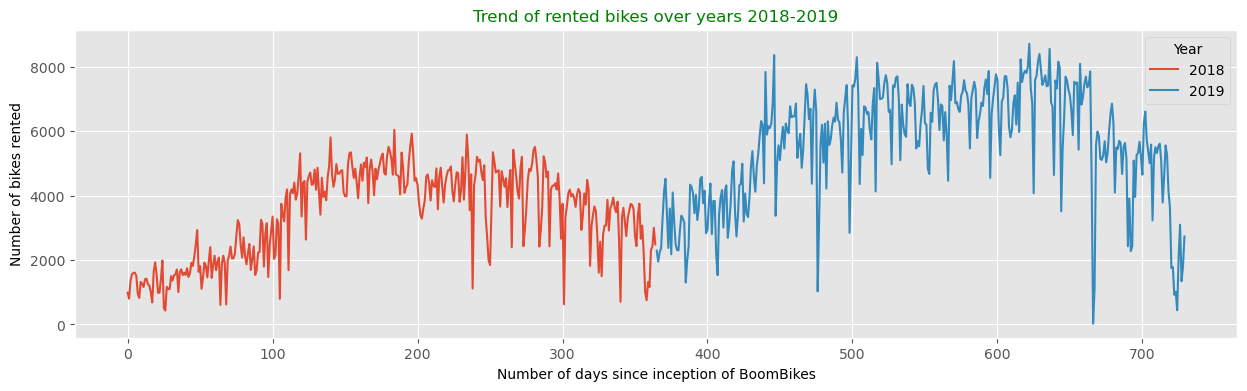

In [24]:
plt.figure(figsize=(15,4))
sns.lineplot(data=inp1,x='days_old', y='count',hue='year')
plt.title('Trend of rented bikes over years 2018-2019', fontdict={'fontsize':12,'fontweight':10,'color':'Green'})
plt.xlabel('Number of days since inception of BoomBikes')
plt.ylabel('Number of bikes rented')
L=plt.legend()
L.get_texts()[0].set_text('2018')
L.get_texts()[1].set_text('2019')
L.set_title('Year')
plt.show()

**Observation**<br>
1. demand curve for rented bikes almost similar in the years 2018 and 2019 in ratio.<br>
2. Dips in the demands are more severe in 2019 and occur in the first and later half of the year.<br>

**2. pairplot of features on the target to understand relationship**

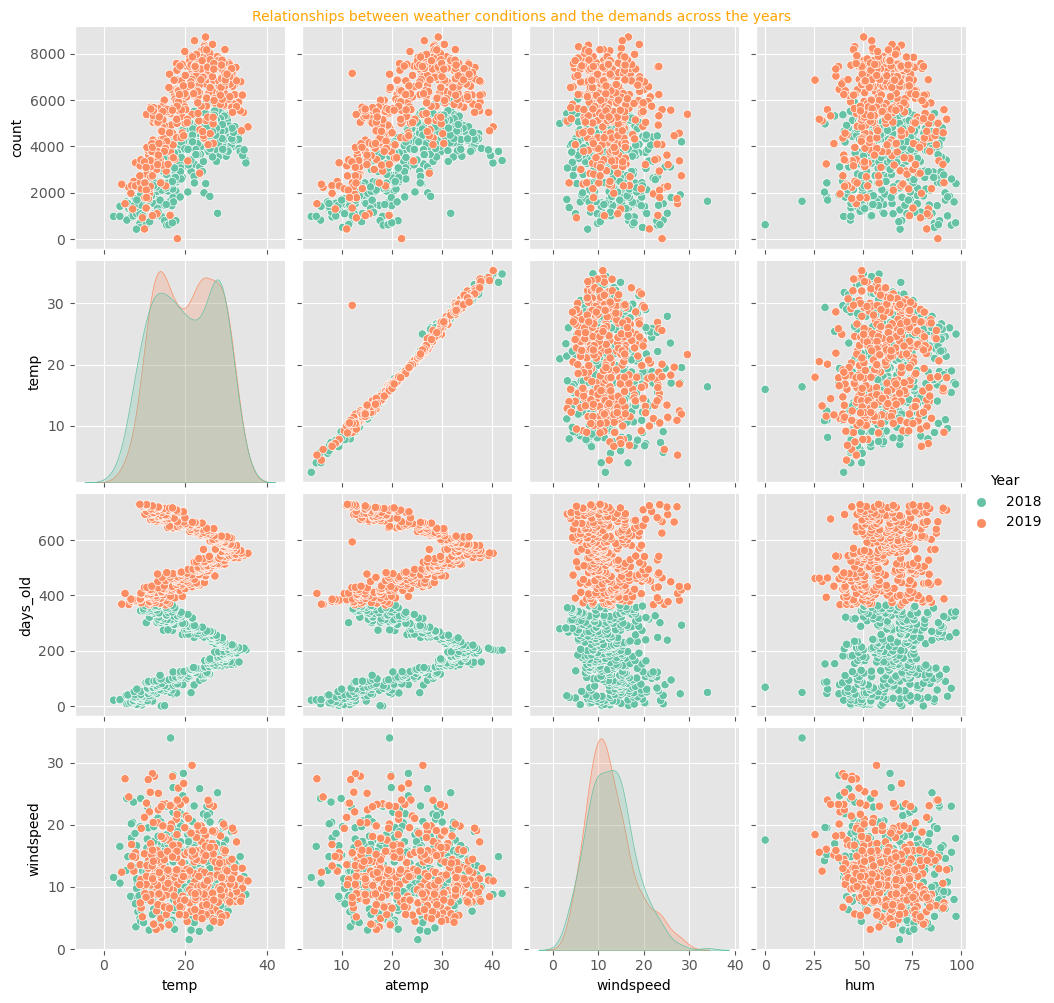

In [25]:
L = sns.pairplot(inp1, x_vars=['temp','atemp', 'windspeed','hum'],y_vars=['count','temp','days_old','windspeed'],
                 hue ='year',palette='Set2')
L.fig.suptitle('Relationships between weather conditions and the demands across the years',y=1,fontsize=10,color='Orange')
L._legend.set_title('Year')
L._legend.get_texts()[0].set_text('2018')
L._legend.get_texts()[1].set_text('2019')
plt.show()

**Observations**<br>
1. increasing trend of demand with increasing temp and atemp with peaks between 20-30 degree celsius.<br>
2. temp and atemp have a positive increasing relationship.<br>
3. bike rentals are highest when windspeed is around 10-15 km/h.<br>
4. windspeed was higher in the year 2019 and so was the demand.<br>
5. majority of bike rentals are when humidity is within 50 and 80 g.m-3.<br>
6. temperature was comparatively higher in 2019 than 2018 but that did not stop the demand.<br>
7. Rise and low of temperature, windspeed & humidity between 2018 and 2019 follow same pattern.<br>

**3. Correlation between the features**

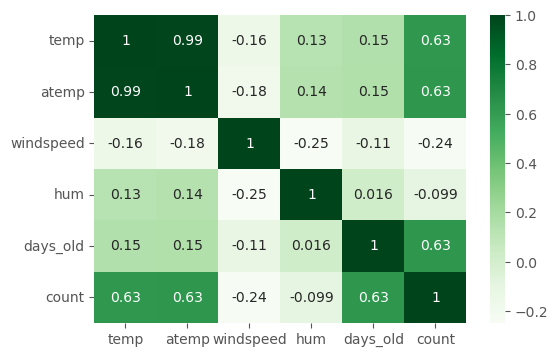

In [26]:
#correlation of continuous features
plt.figure(figsize=(6,4))
sns.heatmap(inp1[['temp','atemp','windspeed','hum','days_old','count']].corr(), cmap="Greens",annot=True)
plt.show()

In [27]:
#correlation of categorical features

**3. plot on relationship between months,season,weekday,weatherit and demand across the years**

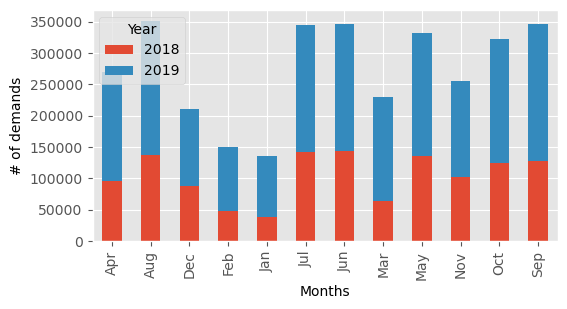

In [28]:
#plt.subplot(2,2,1)
inp1.pivot_table(index = 'month',columns='year',values='count', 
                  aggfunc=np.sum ).plot(kind='bar',stacked=True,figsize=[6,3])
   
plt.legend(title='Year',labels=['2018','2019'])
plt.ylabel('# of demands')
plt.xlabel('Months')
plt.show()

In [29]:
#graph on 1. stacked barchart for months/count/hue=year, 2. boxplot for outliers with describe(), 3. barhcart on season/
#cout/hue=year, 4. heatmap, 5. correlation on continuous and categorical values : holiday & weekday/weekend
# relatinship b/w season and months = visualise using charts
#identify features/variables that shows a relation = multi-variate linear regression

## IV - Data Preparation

**1. Create dummy variables for all categorical features: season, weathersit, month, weekday**

In [30]:
#season
status_s = pd.get_dummies(inp1['season'])
status_s.value_counts()

Fall  Spring  Summer  Winter
1     0       0       0         188
0     0       1       0         184
      1       0       0         180
      0       0       1         178
dtype: int64

Seasons are identifed as follows:<br>
    1. `1000` will correspond to  `fall`<br>
    2. `0010` will correspond to `spring`<br>
    3. `0100` will correspond to `summer`<br>
    4. `0001` will correspond to `winter`<br>
`fall` columns is redundant so dropping it therefore seasons are now identified as follows:<br>
    1. `000` will correspond to `fall`<br>
    2. `010` will correspond to `spring`<br>
    3. `100` will correspond to `summer`<br>
    4. `001` will correspond to `winter`<br>

In [31]:
#drop column fall from the dummies
status_s = pd.get_dummies(inp1['season'],drop_first=True)
status_s.value_counts()

Spring  Summer  Winter
0       0       0         188
        1       0         184
1       0       0         180
0       0       1         178
dtype: int64

In [32]:
#inp1 = EDA dataset
#inp2 = copy of inp1; dummy variable additions with dropping of categorical features
inp2 = inp1.copy()
inp2 = pd.concat([inp2,status_s],axis=1)
inp2.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,count,days_old,Spring,Summer,Winter
0,Spring,0,Jan,0,Sat,0,Misty,14.11,18.18,80.58,10.75,985,0,1,0,0
1,Spring,0,Jan,0,Sun,0,Misty,14.90,17.69,69.61,16.65,801,1,1,0,0
2,Spring,0,Jan,0,Mon,1,Clear,8.05,9.47,43.73,16.64,1349,2,1,0,0
3,Spring,0,Jan,0,Tue,1,Clear,8.20,10.61,59.04,10.74,1562,3,1,0,0
4,Spring,0,Jan,0,Wed,1,Clear,9.31,11.46,43.70,12.52,1600,4,1,0,0


In [33]:
#repeat for  month, weekday & weathersit
status_m = pd.get_dummies(inp1['month'],drop_first=True)
status_w = pd.get_dummies(inp1['weekday'],drop_first=True)
status_wit = pd.get_dummies(inp1['weathersit'],drop_first=True)
inp2 = pd.concat([inp2,status_m,status_w,status_wit],axis=1)

#drop the categorical columns
inp2.drop(['season','month','weekday','weathersit'],axis=1,inplace=True)

inp2.head()

,year,holiday,workingday,temp,atemp,hum,windspeed,count,days_old,Spring,...,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light_snrn,Misty
0,0,0,0,14.11,18.18,80.58,10.75,985,0,1,...,0,0,0,1,0,0,0,0,0,1
1,0,0,0,14.90,17.69,69.61,16.65,801,1,1,...,0,0,0,0,1,0,0,0,0,1
2,0,0,1,8.05,9.47,43.73,16.64,1349,2,1,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.20,10.61,59.04,10.74,1562,3,1,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,9.31,11.46,43.70,12.52,1600,4,1,...,0,0,0,0,0,0,0,1,0,0


In [34]:
print(list(inp2.columns))

['year', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'count', 'days_old', 'Spring', 'Summer', 'Winter', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', 'Light_snrn', 'Misty']


**2. Divide dataset into train & test datasets**

In [35]:
#divide dataset into train & test datasets in 70:30 ratio
np.random.seed(0)
inp2_train, inp2_test = train_test_split(inp2, train_size = 0.7, test_size = 0.3, random_state = 100)
print('Train dataset size =',inp2_train.shape)
print('Test dataset size =',inp2_test.shape)

Train dataset size = (510, 31)
Test dataset size = (219, 31)


**3. Perform scaling of continuous variables : temp, atemp, hum, windspeed,count**

In [36]:
scaler = MinMaxScaler()
num_vars = ['temp','atemp','hum','windspeed','count','days_old']
inp2_train[num_vars] = scaler.fit_transform(inp2_train[num_vars])
inp2_train.head()

,year,holiday,workingday,temp,atemp,hum,windspeed,count,days_old,Spring,...,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light_snrn,Misty
653,1,0,1,0.509875,0.501181,0.575330,0.300930,0.864243,0.896978,0,...,1,0,0,0,0,0,1,0,0,0
576,1,0,1,0.815254,0.766343,0.725680,0.264678,0.827658,0.791209,0,...,0,0,0,0,0,0,1,0,0,0
426,1,0,0,0.442419,0.438960,0.640148,0.255374,0.465255,0.585165,1,...,0,0,0,1,0,0,0,0,0,1
728,1,0,0,0.245214,0.200315,0.498042,0.663138,0.204096,1.000000,1,...,0,0,0,0,1,0,0,0,0,0
482,1,0,0,0.395624,0.391966,0.504534,0.188643,0.482973,0.662088,0,...,0,0,0,1,0,0,0,0,0,1


**4. Divide dataset features into dependent & independent variables**

In [37]:
#depedent variable = count
#indepdent variable = rest of features

y_train = inp2_train.pop('count')
X_train = inp2_train

## V - Linear Regression model building

**1. Recursive Feature Elimination (RFE) on the X_train & y_train to find relevant independent features**

In [38]:
#RFE - Recursive feature elimination
lm = LinearRegression()
lm.fit(X_train,y_train)

rfe = RFE(lm,n_features_to_select=25)
rfe = rfe.fit(X_train,y_train)

In [39]:
#list the output of RFE rankig
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('year', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('days_old', True, 1),
 ('Spring', True, 1),
 ('Summer', True, 1),
 ('Winter', True, 1),
 ('Aug', True, 1),
 ('Dec', True, 1),
 ('Feb', True, 1),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Jun', False, 4),
 ('Mar', False, 6),
 ('May', True, 1),
 ('Nov', True, 1),
 ('Oct', True, 1),
 ('Sep', True, 1),
 ('Mon', True, 1),
 ('Sat', True, 1),
 ('Sun', True, 1),
 ('Thu', False, 3),
 ('Tue', False, 2),
 ('Wed', False, 5),
 ('Light_snrn', True, 1),
 ('Misty', True, 1)]

In [60]:
#features selected by RFE
col = X_train.columns[rfe.support_]
print(list(col))

['year', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'days_old', 'Spring', 'Summer', 'Winter', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'May', 'Nov', 'Oct', 'Sep', 'Mon', 'Sat', 'Sun', 'Light_snrn', 'Misty']


In [61]:
#features not selected by RFE
print(list(X_train.columns[~rfe.support_]))

['Jun', 'Mar', 'Thu', 'Tue', 'Wed']


**2. Iteration of building the model based on RFE**

**2.1 Model 1 : based on all indepdent features determined from RFE**

In [62]:
#relevant independent features determined by RFE
X_train_rfe = X_train[col]
X_train_rfe.shape

(510, 25)

In [63]:
#add constant; build the linear model
X_train_rfe = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_rfe).fit()

In [64]:
#Model 1 statistics
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     117.1
Date:                Fri, 25 Aug 2023   Prob (F-statistic):          1.50e-184
Time:                        00:43:35   Log-Likelihood:                 527.16
No. Observations:                 510   AIC:                            -1004.
Df Residuals:                     485   BIC:                            -898.5
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2478      0.038      6.542      0.0

**Observation**<br>
1. Features atemp, days_old, Aug, Dec, Feb, Jul, May, Nov, Oct, Mon, Sun are dropped since the p-value is high in comparison to the p-value of other features.<br>
2. R2 is 85.3 and adjusted R2 is 84.6 with probability of F-statistic well below 0.05 implying a good model fit.

**2.2 Model 2 : without features holiday, atemp & days_old**

In [65]:
#copy model 2 indepdent features
X_train_m2 = X_train_rfe.copy()

In [66]:
#drop features that are insignificant
X_train_m2 = X_train_m2.drop(['atemp','days_old', 'Aug','Dec','Feb','Jul','May','Nov','Oct','Mon','Sun'],axis=1)

In [67]:
X_train_m2 = sm.add_constant(X_train_m2)
lm = sm.OLS(y_train,X_train_m2).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     194.1
Date:                Fri, 25 Aug 2023   Prob (F-statistic):          1.20e-190
Time:                        00:43:43   Log-Likelihood:                 515.42
No. Observations:                 510   AIC:                            -1001.
Df Residuals:                     495   BIC:                            -937.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2385      0.036      6.597      0.0

**Observation**<br>
1. R2 and adjusted R2 is 84.6 and 84.2 respectively with probability of F-statistics defining a well fit model. <br>
2. p-values of features Spring and Jan are high in comparison to rest. However retain them and check VIF.

In [68]:
#drop constant to find VIF
X_train_m2 = X_train_m2.drop(['const'],axis=1)

In [69]:
#create VIF for Model 2
vif = pd.DataFrame()
X = X_train_m2
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,hum,29.40
3,temp,16.42
2,workingday,5.30
5,windspeed,4.72
6,Spring,4.42
8,Winter,3.33
7,Summer,2.52
13,Misty,2.28
0,year,2.09
11,Sat,1.98


**Observation**<br>
`Guideline:` <br>
    1. VIF > 10 is eliminated due to high multicollinearity.<br>
    2. VIF > 5 is ok but worth inspecting.<br>
    3. VIF < 5 is good.<br>
    <br>
 **Action**<br>
 1. p-values of hum, temp & Good are ideal values therefore remove other relates feature Jan based on high p-values in comparison to rest.<br>
 2. removing features Sat & workingday since they are related

**2.3 Model 3 : without features Sat & workingday**

In [70]:
print(list(X_train_m2.columns))

['year', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'Spring', 'Summer', 'Winter', 'Jan', 'Sep', 'Sat', 'Light_snrn', 'Misty']


In [71]:
#model 3
X_train_m3 = X_train_m2.copy()
X_train_m3 = X_train_m3.drop(['Sat','workingday','Jan'],axis=1)

In [72]:
X_train_m3 = sm.add_constant(X_train_m3)
lm = sm.OLS(y_train,X_train_m3).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     236.2
Date:                Fri, 25 Aug 2023   Prob (F-statistic):          1.41e-189
Time:                        00:46:45   Log-Likelihood:                 504.45
No. Observations:                 510   AIC:                            -984.9
Df Residuals:                     498   BIC:                            -934.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2711      0.035      7.851      0.0

**Observation**<br>
1.R2 and adjusted R2 is 83.9 and 83.6 respectively with probability of F-statistics defining a well fit model.<br>
2. p-values of feature Spring is high in comparison to rest.

In [73]:
#drop constant to find VIF
X_train_m3 = X_train_m3.drop(['const'],axis=1)

#create VIF for Model 3
vif = pd.DataFrame()
X = X_train_m3
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,28.06
2,temp,14.81
4,windspeed,4.65
5,Spring,3.92
7,Winter,3.19
6,Summer,2.45
10,Misty,2.28
0,year,2.08
8,Sep,1.28
9,Light_snrn,1.24


**Observation**<br>
1. p-value of Spring is high in comparison to the rest so remove it but its VIF is ideal so retain it. <br>
2. remove hum to check if overall model fit even though its p-value is ideal.

**2.4 Model 4 : without hum**

In [74]:
print(list(X_train_m3.columns))

['year', 'holiday', 'temp', 'hum', 'windspeed', 'Spring', 'Summer', 'Winter', 'Sep', 'Light_snrn', 'Misty']


In [75]:
#model 4
X_train_m4 = X_train_m3.copy()
X_train_m4 = X_train_m4.drop(['hum'],axis=1)

In [76]:
X_train_m4 = sm.add_constant(X_train_m4)
lm = sm.OLS(y_train,X_train_m4).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     249.2
Date:                Fri, 25 Aug 2023   Prob (F-statistic):          7.45e-187
Time:                        00:48:35   Log-Likelihood:                 495.15
No. Observations:                 510   AIC:                            -968.3
Df Residuals:                     499   BIC:                            -921.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1910      0.030      6.455      0.0

**Observation**<br>
1. R2 is 83.3 and adjusted R2 is 83.0 with probability of F-statistic being low implying well defined model.<br>
2. All p-values of features are now good. 

In [77]:
#drop constant to find VIF
X_train_m4 = X_train_m4.drop(['const'],axis=1)

#create VIF for Model 3
vif = pd.DataFrame()
X = X_train_m4
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,windspeed,4.60
2,temp,3.84
0,year,2.07
4,Spring,2.00
5,Summer,1.89
6,Winter,1.63
9,Misty,1.54
7,Sep,1.23
8,Light_snrn,1.08
1,holiday,1.04


**Observation**<br>
All p-values and VIF are ideal now. Let us proceed with this model and check further.

In [ ]:
#r2_score(y_test, y_pred)a

## VI - Observation